# extract labels and training images

In [ ]:
from pytesseract import image_to_string
import cv2
import numpy as np
import re
import os

In [ ]:
os.listdir(".")

['model.pkl',
 'page107_img1.jpeg',
 'page107_img2.jpeg',
 'page108_img1.jpeg',
 'page108_img2.jpeg',
 'page109_img1.jpeg',
 'page109_img2.jpeg',
 'page10_img1.jpeg',
 'page10_img2.jpeg',
 'page110_img1.jpeg',
 'page110_img2.jpeg',
 'page111_img1.jpeg',
 'page111_img2.jpeg',
 'page112_img1.jpeg',
 'page113_img1.jpeg',
 'page113_img2.jpeg',
 'page114_img1.jpeg',
 'page114_img2.jpeg',
 'page115_img1.jpeg',
 'page115_img2.jpeg',
 'page116_img1.jpeg',
 'page116_img2.jpeg',
 'page117_img1.jpeg',
 'page117_img2.jpeg',
 'page118_img1.jpeg',
 'page118_img2.jpeg',
 'page119_img1.jpeg',
 'page119_img2.jpeg',
 'page11_img1.jpeg',
 'page11_img2.jpeg',
 'page120_img2.jpeg',
 'page121_img1.jpeg',
 'page121_img2.jpeg',
 'page122_img1.jpeg',
 'page122_img2.jpeg',
 'page123_img1.jpeg',
 'page12_img1.jpeg',
 'page12_img2.jpeg',
 'page133_img1.jpeg',
 'page133_img2.jpeg',
 'page134_img1.jpeg',
 'page134_img2.jpeg',
 'page135_img1.jpeg',
 'page135_img2.jpeg',
 'page136_img1.jpeg',
 'page136_img2.jpeg',
 '

In [ ]:
def extract_scale_singleim(image_dir):
  '''
  input:
  image_dir: image directory

  output:
  pixel_length: int
  image_croppeded: numpy array
  '''
  image=cv2.imread(image_dir, 0)
  #crop image
  image_scale=image[670:,435:600]
  image_croppeded=image[:660,:]
  image_scale_bar=image[670:700,420:750]

  #extract scale value
  scale=image_to_string(image_scale).strip()
  scale_value=re.sub("[^0-9]","",scale)
  ##convet mm to um
  scale_value=int(scale_value)
  if scale_value<10:
      scale_value=scale_value*1000
  ##convert um to nm
  scale_value=scale_value*1000

  #extract scale bar length
  _, thresh = cv2.threshold(image_scale_bar, thresh=250, maxval=255, type=cv2.THRESH_BINARY)
  thresh=thresh.sum(axis=0)
  maximum=thresh.max()
  logic=thresh==maximum
  max_i_1=logic.argmax()
  logic=logic[max_i_1+1:]
  max_i_2=logic.argmax()
  logic=logic[max_i_2+1:]
  max_i_3=logic.argmax() + max_i_2 + max_i_1
  bar_length=max_i_3-max_i_1+3

  #how long(nm) for each pixel
  pixel_length=scale_value/bar_length
  return pixel_length, image_croppeded

In [ ]:
def extract_scale(images_dir,sufix=""):
  '''
  input:
  images_dir: str, the directories for images
  sufix: str, the sufix of image

  output:
  pixel_lengths: a list of pixel lengths
  images: a list of numpy arrays of cropped images
  '''
  image_dirs=os.listdir(images_dir)
  pixel_lengths = list()
  images = list()
  for image_dir in image_dirs:
    if re.match(sufix,image_dir) == None:
      continue
    pixel_length, image_croppeded=extract_scale_singleim(image_dir)
    pixel_lengths.append(pixel_length)
    images.append(image_croppeded)
  return pixel_lengths, images

In [ ]:
pixel_lengths, images = extract_scale(".")

TypeError: 'NoneType' object is not subscriptable

In [ ]:
images[2].shape

In [ ]:
#import pickle
#pickle.dump(pixel_lengths,open("../pixel_lengths.pkl","wb"))
#pickle.dump(images,open("../images.pkl","wb"))

In [ ]:
import pickle
with open("../pixel_lengths.pkl","rb") as f:
  pixel_lengths = pickle.load(f)
pass

In [ ]:
with open("../images.pkl","rb") as f:
  images = pickle.load(f)
pass

# transfer learning cnn

## import libraries and model

In [ ]:
#import basic libraries
import tensorflow as tf
import tensorboard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_hub

2025-09-28 19:04:33.733960: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-28 19:04:33.856374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759057473.903677   43692 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759057473.919570   43692 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759057474.033499   43692 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
loaded_base_model = keras_hub.models.Backbone.from_preset("vit_base_patch32_224_imagenet21k")

I0000 00:00:1759057478.373350   43692 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6070 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## Modify positional embedding

In [ ]:
loaded_base_model.layers[-2].position_embedding.weights[0].shape

TensorShape([50, 768])

In [ ]:
#from scipy.interpolate import RegularGridInterpolator
#interpolate position weights to support 2048X2048 images
#position_weights = np.array(loaded_base_model.layers[-2].position_embedding.weights[0])[1:]#exclude [cls]
#cls_vector = np.array(loaded_base_model.layers[-2].position_embedding.weights[0])[0].reshape(1,-1)
#X = np.linspace(1,49,49)
#Y = np.linspace(1,768,768)

#f = RegularGridInterpolator((X,Y),position_weights,method='cubic')

#Xnew = np.linspace(1,49,4096)#4096 patches for new size
#Xnew = np.concatenate([Xnew]*768).reshape(-1,1)
#Ynew = np.concatenate([Y]*4096).reshape(-1,1)
#point = np.concatenate([Xnew,Ynew],axis=1)
#position_weights_2048x2048 = f(point).reshape(4096,768)
#position_weights_2048x2048 = np.concatenate((cls_vector,position_weights_2048x2048),axis=0)

In [ ]:
#create patching_and_embedding layer
from keras_hub.src.models.vit.vit_layers import ViTPatchingAndEmbedding
from keras import ops
@tf.keras.utils.register_keras_serializable(package="MyLayers", name="ViTPEWithoutPos")
class ViTPEWithoutPos(ViTPatchingAndEmbedding):
  def build(self, input_shape):
        super().build(input_shape)
        self.position_embedding = None
  def call(self, inputs):
        patch_embeddings = self.patch_embedding(inputs)
        if self.data_format == "channels_first":
            patch_embeddings = ops.transpose(
                patch_embeddings, axes=(0, 2, 3, 1)
            )
        embeddings_shape = ops.shape(patch_embeddings)
        patch_embeddings = ops.reshape(
            patch_embeddings, [embeddings_shape[0], -1, embeddings_shape[-1]]
        )

        if self.use_class_token:
            class_token = ops.tile(
                self.class_token, (embeddings_shape[0], 1, 1)
            )
            patch_embeddings = ops.concatenate(
                [class_token, patch_embeddings], axis=1
            )
        return patch_embeddings

In [ ]:
vit_patching_and_embedding_256x256 = ViTPEWithoutPos(image_size=(256,256),patch_size=(32,32),hidden_dim=768,num_channels=1,name="vit_patching_and_embedding")

In [ ]:
vit_patching_and_embedding_256x256.build((None,256,256,1))

In [ ]:
patch_embedding_weights = [np.sum(loaded_base_model.layers[-2].patch_embedding.weights[0],axis=2,keepdims=True)]
patch_embedding_weights += [loaded_base_model.layers[-2].patch_embedding.weights[1]]
vit_patching_and_embedding_256x256.patch_embedding.set_weights(patch_embedding_weights)

In [ ]:
loaded_base_model.layers

[<InputLayer name=images, built=True>,
 <ViTPatchingAndEmbedding name=vit_patching_and_embedding, built=True>,
 <ViTEncoder name=vit_encoder, built=True>]

## modify the input shape for multihead attention

In [ ]:
import keras
@tf.keras.utils.register_keras_serializable(package="MyLayers", name="ViTEncoderBlockLocal")
class ViTEncoderBlockLocal(keras_hub.src.models.vit.vit_layers.ViTEncoderBlock):
  def build(self, input_shape):
        # Attention block
        self.layer_norm_1 = keras.layers.LayerNormalization(
            epsilon=self.layer_norm_epsilon,
            name="ln_1",
            dtype=self.dtype_policy,
        )
        self.layer_norm_1.build(input_shape)
        self.mha = keras.layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.key_dim,
            use_bias=self.use_mha_bias,
            dropout=self.attention_dropout,
            name="mha",
            dtype=self.dtype_policy,
        )
        self.mha.build(input_shape, input_shape)
        self.dropout = keras.layers.Dropout(
            self.dropout_rate, dtype=self.dtype_policy, name="dropout"
        )

        # MLP block
        self.layer_norm_2 = keras.layers.LayerNormalization(
            epsilon=self.layer_norm_epsilon,
            name="ln_2",
            dtype=self.dtype_policy,
        )
        self.layer_norm_2.build((None, None, self.hidden_dim))
        self.mlp = keras_hub.src.models.vit.vit_layers.MLP(
            hidden_dim=self.hidden_dim,
            mlp_dim=self.mlp_dim,
            use_bias=self.use_mlp_bias,
            dropout_rate=self.dropout_rate,
            name="mlp",
            dtype=self.dtype_policy,
        )
        self.mlp.build((None, None, self.hidden_dim))

        #calculate shapes
        self.emb_dim = input_shape[-1]

        if input_shape[1] != None:
            self.patch_n = input_shape[1]
            self.p_sqrt = tf.cast(tf.sqrt(tf.cast(total_patch_n,tf.float32)),tf.int32)
        else:
            self.patch_n = None
            self.p_sqrt = None

        self.built = True


  def call(self, inputs):
        x = self.layer_norm_1(inputs)
        batch_size = tf.shape(x)[0]
        cls = x[:,0,:]
        cls = tf.reshape(cls, (batch_size,1,self.emb_dim)) #keep the shape

        #attention for patch
        patch = x[:,1:,:]

        if self.patch_n != None:
            total_patch_n = self.patch_n
            p_sqrt = self.p_sqrt
        else:
          #if none, calculate patch dynamically
          total_patch_n = tf.shape(patch)[1]
          p_sqrt = tf.cast(tf.sqrt(tf.cast(total_patch_n,tf.float32)),tf.int32)

        query = tf.reshape(patch, (batch_size * total_patch_n, 1, self.emb_dim))

        key_value = tf.reshape(patch,(batch_size,p_sqrt,p_sqrt,self.emb_dim))
        key_value = keras.ops.image.extract_patches(
            images=key_value,
            size=[3,3],
            padding='same',
            strides=1)
        key_value = tf.reshape(key_value, (batch_size * total_patch_n, 9, self.emb_dim))


        patch_result = self.mha(query, key_value) #local query, attention_axes=1, output = (tf.shape(patch_result)[0] * total_patch_n,1,tf.shape(patch_result)[3])
        patch_result = tf.reshape(patch_result,(batch_size,total_patch_n,self.emb_dim))#convert back to the same shape as input

        cls_result = self.mha(cls, x) #global query, attention_axes=1

        x = tf.concat([cls_result,patch_result],axis=1) #get the x and all the same for the rest
        x = self.dropout(x)
        x = x + inputs

        y = self.layer_norm_2(x)
        y = self.mlp(y)

        return x + y

@tf.keras.utils.register_keras_serializable(package="MyLayers", name="MyVitEncoder")
class MyVitEncoder(keras_hub.src.models.vit.vit_layers.ViTEncoder):
  def __init__(
        self,
        EncoderBlock = keras_hub.src.models.vit.vit_layers.ViTEncoderBlock, #support predefined encoder block
        **kwargs
    ):
        super().__init__(**kwargs)
        self.EncoderBlock = EncoderBlock #set the predefined encoder block


  def build(self, input_shape):
        self.encoder_layers = []
        for i in range(self.num_layers):
            encoder_block = self.EncoderBlock( #replace it with predefined encoder block
                num_heads=self.num_heads,
                hidden_dim=self.hidden_dim,
                mlp_dim=self.mlp_dim,
                dropout_rate=self.dropout_rate,
                use_mha_bias=self.use_mha_bias,
                use_mlp_bias=self.use_mlp_bias,
                attention_dropout=self.attention_dropout,
                layer_norm_epsilon=self.layer_norm_epsilon,
                dtype=self.dtype_policy,
                name=f"tranformer_block_{i + 1}",
            )
            encoder_block.build((None, None, self.hidden_dim))
            self.encoder_layers.append(encoder_block)
        self.dropout = keras.layers.Dropout(
            self.dropout_rate, dtype=self.dtype_policy, name="dropout"
        )
        self.layer_norm = keras.layers.LayerNormalization(
            epsilon=self.layer_norm_epsilon,
            dtype=self.dtype_policy,
            name="ln",
        )
        self.layer_norm.build((None, None, self.hidden_dim))
        self.built = True

In [ ]:
encoder_config = loaded_base_model.layers[2].get_config()
local_encoder = MyVitEncoder(EncoderBlock=ViTEncoderBlockLocal,**encoder_config)

In [ ]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(None,None,1),name="images"),
    vit_patching_and_embedding_256x256,
    local_encoder
],name='vit_backbone_hd')

In [ ]:
#set encoder weights to loaded model weights
base_model.layers[-1].set_weights(loaded_base_model.layers[-1].get_weights())

In [ ]:
base_model.summary()

Model: "vit_backbone_hd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vit_patching_and_embedding      │ (None, 65, 768)        │       837,888 │
│ (ViTPEWithoutPos)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vit_encoder (MyVitEncoder)      │ (None, 65, 768)        │    85,056,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,893,888 (327.66 MB)

 Trainable params: 85,893,888 (327.66 MB)

 Non-trainable params: 0 (0.00 B)

## train model

In [ ]:

converter = keras_hub.layers.ImageConverter.from_preset(
    "vit_base_patch32_224_imagenet21k",
    image_size = (256,256),
    scale = 0.00784313725490196,
    offset = -1,
    interpolation = "nearest",
)

In [ ]:
# this model assumes all input images are 660X885
# so I need to rescale the output
@tf.keras.utils.register_keras_serializable(package="MyLayers", name="Scale")
class Scale(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__()

    # Defines the computation
    def call(self, inputs):
      output=885/tf.keras.ops.shape(inputs)[-2]
      output=tf.cast(output,tf.dtypes.float16)
      output=tf.broadcast_to(output,[tf.shape(inputs)[0],1])
      return output

@tf.keras.utils.register_keras_serializable(package="MyLayers", name="Rescale")
class Rescale(tf.keras.layers.Layer):
  #assume the scale is the last element of tensor
  #put this layer after the output layer
    def __init__(self,**kwargs):
        super().__init__()

    # Defines the computation
    def call(self, inputs):
      return tf.keras.ops.prod(inputs,axis=-1,keepdims=True)

In [ ]:
input_image=tf.keras.Input(shape=(None,None,None))
width=Scale()(input_image)
x=converter(input_image)
x=keras.ops.reshape(x[:,:,:,-1],(-1,256,256,1))
x=tf.keras.layers.RandomFlip()(x)
x=base_model(x)
x=x[:,0,:]
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(8,activation="gelu",use_bias=False,kernel_initializer="he_uniform")(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(1)(x)
x=tf.keras.ops.concatenate([x,width],-1)
output=Rescale()(x)

model=tf.keras.Model(input_image,output)

for layer in base_model.layers:
  #freeze the base model layers
  layer.trainable = False

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, None)       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vi_t_image_convert… │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (ViTImageConverter) │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256, 256)  │          0 │ vi_t_image_conve… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 256, 256,  │          0 │ get_item[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 256, 256,  │          0 │ reshape[0][0]     │
│ (RandomFlip)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vit_backbone_hd     │ (None, 65, 768)   │ 85,893,888 │ random_flip[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 768)       │          0 │ vit_backbone_hd[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 768)       │      3,072 │ get_item_1[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │      6,144 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          9 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale (Scale)       │ (None, 1)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2)         │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ scale[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescale (Rescale)   │ (None, 1)         │          0 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,903,145 (327.69 MB)

 Trainable params: 7,705 (30.10 KB)

 Non-trainable params: 85,895,440 (327.67 MB)

In [ ]:
from sklearn.model_selection import train_test_split
images=np.array(images)
images=images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
pixel_lengths=np.array(pixel_lengths)
X_train, X_val, y_train, y_val = train_test_split(images, pixel_lengths, test_size=0.1, random_state=42,shuffle=True)

In [ ]:
loss=tf.keras.losses.MeanSquaredLogarithmicError()
metric=tf.keras.metrics.MeanAbsolutePercentageError()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5), loss=loss, metrics=[metric])

In [ ]:
#train output layer
import datetime
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

def schedule(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr*0.95


In [ ]:
#fit
history=model.fit(X_train,
                  y_train,
                  epochs=100,
                  validation_data=(X_val, y_val),
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                      tf.keras.callbacks.LearningRateScheduler(schedule),
                      tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1),
                      tf.keras.callbacks.ModelCheckpoint('../best_hd_model_frozen.keras',save_best_only=True)],
                  batch_size=32)

Epoch 1/100


I0000 00:00:1759057554.649761   43812 service.cc:152] XLA service 0x7feb1c00c0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759057554.649791   43812 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-09-28 19:05:54.911261: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759057556.368168   43812 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-09-28 19:05:57.536897: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_198', 184 bytes spill stores, 184 bytes spill loads

2025-09-28 19:05:57.843122: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusi

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 20.4492 - mean_absolute_percentage_error: 93.5944

2025-09-28 19:06:08.197383: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_198', 4900 bytes spill stores, 4896 bytes spill loads

2025-09-28 19:06:08.209578: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14', 344 bytes spill stores, 344 bytes spill loads

2025-09-28 19:06:08.343708: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_198', 412 bytes spill stores, 412 bytes spill loads

2025-09-28 19:06:08.407264: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_198', 608 bytes spill stores, 540 bytes spill loads

2025-09-28 19:06:08.591449: I exter

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - loss: 19.7351 - mean_absolute_percentage_error: 93.0025

2025-09-28 19:06:15.651827: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14', 184 bytes spill stores, 184 bytes spill loads

2025-09-28 19:06:15.735392: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_220', 908 bytes spill stores, 908 bytes spill loads

2025-09-28 19:06:15.952906: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_220', 428 bytes spill stores, 336 bytes spill loads

2025-09-28 19:06:16.030545: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_220', 300 bytes spill stores, 300 bytes spill loads

2025-09-28 19:06:16.095320: I externa

11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 12.5941 - mean_absolute_percentage_error: 87.0841 - val_loss: 3.4890 - val_mean_absolute_percentage_error: 75.3731 - learning_rate: 0.5000
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 717ms/step - loss: 4.5741 - mean_absolute_percentage_error: 71.2493 - val_loss: 2.1557 - val_mean_absolute_percentage_error: 62.3432 - learning_rate: 0.5000
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 716ms/step - loss: 3.4396 - mean_absolute_percentage_error: 67.1670 - val_loss: 1.5757 - val_mean_absolute_percentage_error: 53.0676 - learning_rate: 0.5000
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 709ms/step - loss: 2.8571 - mean_absolute_percentage_error: 65.3353 - val_loss: 1.2780 - val_mean_absolute_percentage_error: 49.4638 - learning_rate: 0.5000
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 726ms/step - loss: 2.5308 - mean_absolute_percentage_error: 65.5736 - val_loss: 1.0967 - val_mean_absolute_percentage_error: 48.1250 - learning_rate: 0.5000
Epoch 6/100
11/11 

In [ ]:
model.load_weights("../best_hd_model_frozen.keras")

FileNotFoundError: [Errno 2] No such file or directory: '../best_hd_model_frozen.keras'

In [ ]:
model.load_weights("best_hd_model_frozen.weights.h5")

## unfreeze some layers

In [ ]:
model.layers[3].layers[-1].encoder_layers[-1].trainable = True

In [ ]:
loss=tf.keras.losses.MeanSquaredLogarithmicError()
metric=tf.keras.metrics.MeanAbsolutePercentageError()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss=loss, metrics=[metric])

In [ ]:
#fit
history=model.fit(X_train,
                  y_train,
                  epochs=100,
                  validation_data=(X_val, y_val),
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                      tf.keras.callbacks.LearningRateScheduler(schedule),
                      tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1),
                      tf.keras.callbacks.ModelCheckpoint('../best_hd_model.keras',save_best_only=True)],
                  batch_size=32)

Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-140163821.py", line 2, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

Out of memory while trying to allocate 4848615424 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_80226]

In [ ]:
model.summary()

# Evaluate Model

In [ ]:
image=cv2.imread("/mnt/c/Users/45709/Capstone_Project/SEM_METADATA/Evaluation_data/A.tif", 0)

In [ ]:
image=image.reshape(1,image.shape[0],image.shape[1],1)

In [ ]:
image.shape

(1, 770, 1024, 1)

In [ ]:
model.predict(image)

NameError: name 'model' is not defined

In [ ]:
251*324.87033/1000

81.54245283000002

In [ ]:
image = X_val[31]

In [ ]:
label = y_val[31]

In [ ]:
image=image.reshape(1,image.shape[0],image.shape[1],1)

In [ ]:
model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[238.20097]], dtype=float32)

In [ ]:
label

np.float64(353.35689045936397)

In [ ]:
image=cv2.imread("/mnt/c/Users/45709/Capstone_Project/SEM_METADATA/Evaluation_data/BAT405_001.tif", 0)

In [ ]:
image=image.reshape(1,image.shape[0],image.shape[1],1)

In [ ]:
model.predict(image)

In [ ]:
756*353.35689045936397/1000

267.1378091872791

In [ ]:
image=cv2.imread("/mnt/c/Users/45709/Capstone_Project/SEM_METADATA/Evaluation_data/Large_area-map-Verios.TIF", 0)

In [ ]:
image=image.reshape(1,image.shape[0],image.shape[1],1)

In [ ]:
model.predict(image)

I0000 00:00:1758632460.853565   15374 service.cc:152] XLA service 0x7fdaf80021e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758632460.853586   15374 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-09-23 21:01:00.920272: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758632461.180335   15374 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-09-23 21:01:02.316804: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126_0', 500 bytes spill stores, 912 bytes spill loads

2025-09-23 21:01:02.317178: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fu

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1758632464.232159   15374 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


array([[247.74829]], dtype=float32)

In [ ]:
101*247.75743/1000

25.02350043

## consistancy test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


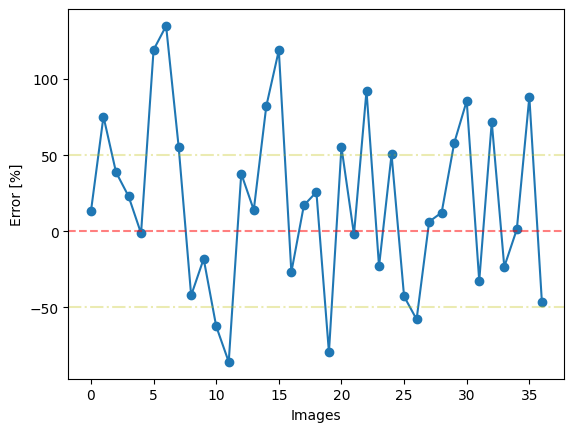

In [ ]:
predictions = model.predict(X_val)
predictions = pd.DataFrame({'pred':predictions.reshape(-1),'truth':y_val})
predictions = predictions.apply(lambda x : ((x['pred']-x['truth'])/x['truth'])*100,axis=1)
plt.plot(predictions, '-o')
plt.xlabel('Images')
plt.ylabel('Error [%]')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=50, color='y', linestyle='-.', alpha=0.3)
plt.axhline(y=-50, color='y', linestyle='-.', alpha=0.3)
plt.show()

In [ ]:
errors

0.49247265584254907

In [ ]:
pd.DataFrame(evaluation)

ValueError: If using all scalar values, you must pass an index

# attention rollout map

In [ ]:
seq = model.layers[:4]
attention_prediction = tf.keras.Sequential(seq)

In [ ]:
attention_prediction.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vi_t_image_converter            │ (None, 224, 224, 3)    │             0 │
│ (ViTImageConverter)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_13 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_backbone (ViTBackbone)     │ (None, 50, 768)        │    87,455,232 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,455,232 (333.62 MB)

 Trainable params: 87,455,232 (333.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
attention_output=attention_prediction.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


In [ ]:
model.layers[3].layers[-1].encoder_layers[0].mha

<ViTEncoder name=vit_encoder, built=True>

In [ ]:
model.layers[3].layers[-1].weights

[<Variable path=vit_encoder/tranformer_block_1/ln_1/gamma, shape=(768,), dtype=float32, value=[0.05967442 0.15965936 0.16814008 0.08800096 0.12828965 0.05542477
  0.11550008 0.18144831 0.19916369 0.18839933 0.10004942 0.2145762
  0.18949422 0.18449044 0.20716023 0.12233839 0.15785281 0.17183979
  0.13168783 0.20835668 0.1891575  0.05211667 0.12093622 0.19563675
  0.12218945 0.10641309 0.13291691 0.14067863 0.11350758 0.19074708
  0.1346639  0.19314997 0.18952079 0.19094141 0.15365003 0.17192645
  0.19294974 0.20327593 0.17148453 0.12388868 0.17999414 0.1434129
  0.15098763 0.19814722 0.22170436 0.11455257 0.15100996 0.06799219
  0.18049054 0.28443706 0.24079235 0.1732035  0.13817418 0.08976421
  0.10594165 0.19905421 0.18995102 0.12907122 0.21211539 0.15020315
  0.203505   0.15465996 0.11218411 0.15710205 0.09881924 0.14748535
  0.23122706 0.2254305  0.13772742 0.13655654 0.15375322 0.1805431
  0.18750052 0.05656478 0.19714268 0.044934   0.10195977 0.14511402
  0.14337415 0.20255078 0.

In [ ]:
import keras
class ViTEncoderBlockWeight(keras_hub.src.models.vit.vit_layers.ViTEncoderBlock):
  def call(self, inputs):
        x = self.layer_norm_1(inputs)
        x, score = self.mha(x, x, return_attention_scores = True) #return attention score
        x = self.dropout(x)
        x = x + inputs

        y = self.layer_norm_2(x)
        y = self.mlp(y)

        return x + y, score #return score


In [ ]:
config=model.layers[3].layers[-1].get_config()

In [ ]:
my_encoder = MyVitEncoder(EncoderBlock=ViTEncoderBlockWeight,**config)

In [ ]:
my_encoder.get_config()

{'name': 'vit_encoder',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'num_layers': 12,
 'num_heads': 12,
 'hidden_dim': 768,
 'mlp_dim': 3072,
 'use_mha_bias': True,
 'use_mlp_bias': True,
 'dropout_rate': 0.0,
 'attention_dropout': 0.0,
 'layer_norm_epsilon': 1e-06}

In [ ]:
#make new model to get attention rollout
#modify the vit backbone
input = model.layers[3].input
output = my_encoder(model.layers[3].layers[-2].output)
rollout_vit = tf.keras.Model(input, output,name="rollout_vit",)
#reconstruct the model
input = model.input
output = rollout_vit(model.layers[2].output)
rollout_model = tf.keras.Model(input, output,name="rollout_model")

In [ ]:
rollout_model.summary()

Model: "rollout_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, None, None,     │             0 │
│                                 │ None)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_image_converter            │ (None, 224, 224, 3)    │             0 │
│ (ViTImageConverter)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_13 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rollout_vit (Functional)        │ [(None, 50, 768),      │    87,455,232 │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50),    │               │
│                                 │ (None, 12, 50, 50)]    │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,455,232 (333.62 MB)

 Trainable params: 87,455,232 (333.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#transfer weights
rollout_model.layers[3].layers[-1].set_weights(model.layers[3].layers[-1].get_weights())

In [ ]:
rollout_model.layers[3].layers[-1].get_weights()[0]

array([0.05967442, 0.15965936, 0.16814008, 0.08800096, 0.12828965,
       0.05542477, 0.11550008, 0.18144831, 0.19916369, 0.18839933,
       0.10004942, 0.2145762 , 0.18949422, 0.18449044, 0.20716023,
       0.12233839, 0.15785281, 0.17183979, 0.13168783, 0.20835668,
       0.1891575 , 0.05211667, 0.12093622, 0.19563675, 0.12218945,
       0.10641309, 0.13291691, 0.14067863, 0.11350758, 0.19074708,
       0.1346639 , 0.19314997, 0.18952079, 0.19094141, 0.15365003,
       0.17192645, 0.19294974, 0.20327593, 0.17148453, 0.12388868,
       0.17999414, 0.1434129 , 0.15098763, 0.19814722, 0.22170436,
       0.11455257, 0.15100996, 0.06799219, 0.18049054, 0.28443706,
       0.24079235, 0.1732035 , 0.13817418, 0.08976421, 0.10594165,
       0.19905421, 0.18995102, 0.12907122, 0.21211539, 0.15020315,
       0.203505  , 0.15465996, 0.11218411, 0.15710205, 0.09881924,
       0.14748535, 0.23122706, 0.2254305 , 0.13772742, 0.13655654,
       0.15375322, 0.1805431 , 0.18750052, 0.05656478, 0.19714

In [ ]:
ops=tf.keras.ops
def attention_rollout_map(image, attention_score_list, model_type = "usal"):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # Stack the individual attention matrices from individual Transformer blocks.
    attn_mat = ops.stack(attention_score_list)
    attn_mat = ops.squeeze(attn_mat, axis=1)

    # Average the attention weights across all heads.
    attn_mat = ops.mean(attn_mat, axis=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_attn = ops.eye(attn_mat.shape[1])
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / ops.sum(aug_attn_mat, axis=-1)[..., None]
    aug_attn_mat = ops.convert_to_numpy(aug_attn_mat)

    # Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), [image.shape[1],image.shape[0]], interpolation = cv2.INTER_NEAREST)[..., np.newaxis]
    result = mask
    return result

In [ ]:
converter = keras_hub.layers.ImageConverter.from_preset(
    "vit_base_patch32_224_imagenet21k"
)

In [ ]:
image=cv2.imread("/mnt/c/Users/45709/Capstone_Project/SEM_METADATA/Evaluation_data/Large_area-map-Verios.TIF", 0)
image=image.reshape(1,image.shape[0],image.shape[1],1)
ver_output, score_list=rollout_model.predict(image)

I0000 00:00:1758900520.113543    5697 service.cc:152] XLA service 0x7f35a0003ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758900520.113562    5697 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-09-26 23:28:40.183823: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758900520.342733    5697 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-09-26 23:28:41.195193: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_100', 300 bytes spill stores, 300 bytes spill loads

2025-09-26 23:28:41.210930: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusi

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1758900523.180772    5697 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [ ]:
image = np.array(converter(image))[0,:,:,0].reshape(224,224,1)

In [ ]:
mask=attention_rollout_map(image, score_list)

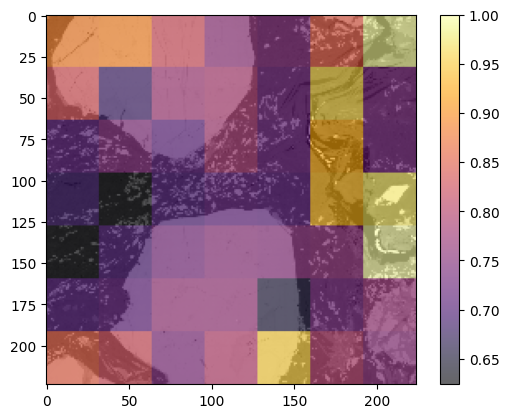

In [ ]:
plt.imshow(image,cmap="grey")
plt.imshow(mask,cmap="inferno", alpha = 0.6)
plt.colorbar()
plt.show()

In [ ]:
#double check my weight
input1 = model.input
input2 = model.layers[4].input
output = model.layers[-1].output
verification_model = tf.keras.Model(inputs=[input1,input2],outputs=output, name="verification_model")

In [ ]:
verification_model.summary()

Model: "verification_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_9CLONE │ (None, 50, 768)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ keras_tensor_9CL… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 768)       │      3,072 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 8)         │      6,144 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dense_23[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, None)       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 1)         │          9 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale (Scale)       │ (None, 1)         │          0 │ input_layer_16[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 2)         │          0 │ dense_24[1][0],   │
│ (Concatenate)       │                   │            │ scale[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescale (Rescale)   │ (None, 1)         │          0 │ concatenate_13[1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,257 (36.16 KB)

 Trainable params: 7,705 (30.10 KB)

 Non-trainable params: 1,552 (6.06 KB)

In [ ]:
verification_model.predict([image,ver_output])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[322.01215]], dtype=float32)

In [ ]:
model.predict(image)

I0000 00:00:1758708696.452764   10282 service.cc:152] XLA service 0x7f17100ba010 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758708696.452786   10282 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-09-24 18:11:36.497176: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1758708697.155296   10282 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


array([[247.59666]], dtype=float32)

In [ ]:
tf.keras.utils.clear_session()

## other images

In [ ]:
image=cv2.imread("/mnt/c/Users/45709/Capstone_Project/SEM_METADATA/Evaluation_data/BAT405_001.tif", 0)

In [ ]:
image=image.reshape(1,image.shape[0],image.shape[1],1)
ver_output, score_list=rollout_model.predict(image)
image = np.array(converter(image))[0,:,:,0].reshape(224,224,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [ ]:
mask=attention_rollout_map(image, score_list)

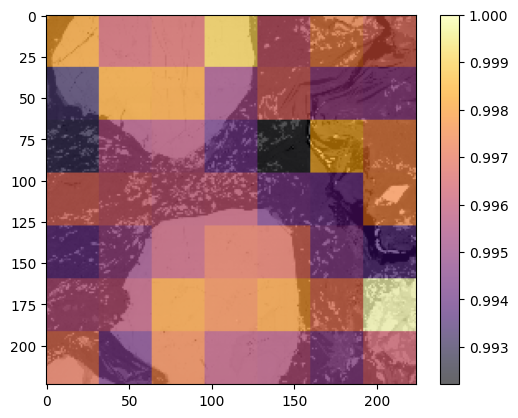

In [ ]:
plt.imshow(image,cmap="grey")
plt.imshow(mask,cmap="inferno", alpha = 0.6)
plt.colorbar()
plt.show()

In [ ]:
image=cv2.imread("/mnt/c/Users/45709/Capstone_Project/SEM_METADATA/Evaluation_data/A.tif", 0)

In [ ]:
image=image.reshape(1,image.shape[0],image.shape[1],1)
ver_output, score_list=rollout_model.predict(image)
image = np.array(converter(image))[0,:,:,0].reshape(224,224,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [ ]:
mask=attention_rollout_map(image, score_list)

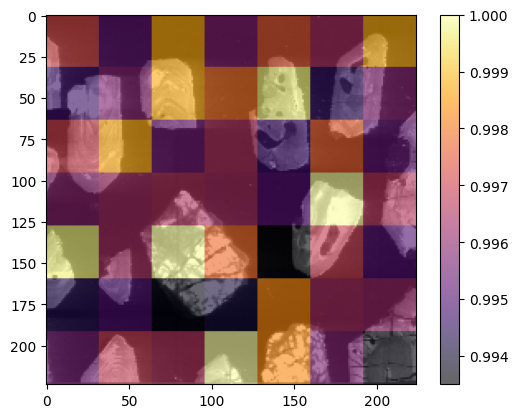

In [ ]:
plt.imshow(image,cmap="grey")
plt.imshow(mask,cmap="inferno", alpha = 0.6)
plt.colorbar()
plt.show()

# Reference

[1] A. Dosovitskiy et al., “An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale,” 2020, doi: 10.48550/arxiv.2010.11929.


  
[2]I. Beltagy, M. E. Peters, and A. Cohan, “Longformer: The Long-Document Transformer,” 2020, doi: 10.48550/arxiv.2004.05150.
  
